# Import data, python packages, and define customized functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Carol_Copy/Dissertation/dDSP

/content/drive/MyDrive/Carol_Copy/Dissertation/dDSP


In [ ]:
import numpy as np
import pandas as pd
# import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def bi_pr_test(r_c,N):
  df = N-2
  t_value = r_c * np.sqrt(df) / np.sqrt(1-r_c**2)
  p_value = stats.t.sf(abs(t_value), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
  z_u = np.log((1+r_c)/(1-r_c))/2 + 1.96*np.sqrt(1/(N-3))
  z_l = np.log((1+r_c)/(1-r_c))/2 - 1.96*np.sqrt(1/(N-3))
  r_u = (np.exp(2*z_u)-1)/(np.exp(2*z_u)+1)
  r_l = (np.exp(2*z_l)-1)/(np.exp(2*z_l)+1)
  print('t-statistic = %5.3f pvalue = %6.4f df = %2.0f' % (t_value,p_value,df))
  print('95CI = [%4.2f, %4.2f]' % (r_l,r_u))

def CI_conhen(var,mu):
  print("95% Confidence Interval: {}".format(stats.t.interval(0.95, var.size - 1, var.mean(), stats.sem(var))))
  cohen_d = ( var.mean() - mu )/var.std()
  print("cohen_d {}".format(round(cohen_d,2)))

In [ ]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=318378 sha256=cc383351c5307283f4bac80372d7607f94e2ca527c734fc36d7093f11809bf14
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("splithalf")
library("splithalf")

# Matched Pointing Trials (20)
### unsuccessful trials substituted by the average learned route efficiency. (as the method reported in the main text)

In [ ]:
strategy = pd.read_csv('strategy.csv')
strategy['ID'] = strategy.TrialID.apply(lambda x: int(x.split('_')[1]))

In [ ]:
wftrajc = pd.read_csv("ProcessedData/analyzed_trajectory.csv")
trial_info = pd.read_csv("desktop_shortcut_trial_info.csv")
wf = wftrajc.merge(strategy[['Subject','ID','human_coding']]\
                   , how = 'left', left_on = ['Subject','TrialID'], right_on = ['Subject','ID'])\
            .merge(trial_info[['TrialID','short_dis','learn_dis']]\
                   , how = 'left', on = 'TrialID')\
            .drop(['ID'],axis=1)
wf.head()

,Subject,TrialID,Order,Time,grid_distance,human_distance,human_coding,short_dis,learn_dis
0,605,2,13.0,10.0,203.0,152.79,shortcut,203,405
1,605,3,11.0,16.0,302.0,263.82,shortcut,302,548
2,605,4,19.0,15.0,303.0,233.87,shortcut liberal,223,629
3,605,5,10.0,16.0,304.0,252.26,shortcut liberal,264,588
4,605,6,17.0,10.0,203.0,159.53,shortcut,203,731


In [ ]:
def efficiency(x):
  if x['human_coding'] != 'Failure' and x['grid_distance']+0.001 >= x['short_dis']:
    return x['grid_distance']/x['short_dis']
  elif x['human_coding'] != 'Failure' and x['grid_distance']+0.001 < x['short_dis']:
    return 1
  else: return np.nan

wf['efficiency']=wf.apply(efficiency, axis=1)
wf['efficiency']= wf['efficiency'].fillna(2.54)

In [ ]:
wf.head()

,Subject,TrialID,Order,Time,grid_distance,human_distance,ID,human_coding,short_dis,learn_dis,efficiency
0,605,2,13.0,10.0,203.0,152.79,2,shortcut,203,405,1.000000
1,605,3,11.0,16.0,302.0,263.82,3,shortcut,302,548,1.000000
2,605,4,19.0,15.0,303.0,233.87,4,shortcut liberal,223,629,1.358744
3,605,5,10.0,16.0,304.0,252.26,5,shortcut liberal,264,588,1.151515
4,605,6,17.0,10.0,203.0,159.53,6,shortcut,203,731,1.000000


In [ ]:
sub_fail = wf.groupby(['Subject']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
sub_fail[sub_fail['total_failure']>int(20*0.3)]

,Subject,total_failure
32,638,7
33,639,8


In [ ]:
trial_fail = wf.groupby(['TrialID']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
trial_fail[trial_fail['total_failure']>int(wf.Subject.nunique()*0.2)]

,TrialID,total_failure
17,22,17


In [ ]:
print('Participants with > 6 fialure trials : ')
p_sub=sub_fail[sub_fail['total_failure']>6]['Subject'].tolist()
print(p_sub)
print('Trials with > 20% fialure subjects : ')
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()
print(p_trial)

Participants with > 6 fialure trials : 
[638, 639]
Trials with > 20% fialure subjects : 
[22]


In [ ]:
#excluded unsuccessful participants and trials
valid_wf = wf.loc[~(wf['TrialID'].isin(p_trial) | wf['Subject'].isin(p_sub)),:]

In [ ]:
valid_wf[valid_wf.human_coding != 'Failure'].shape[0]/valid_wf.shape[0]

0.9289012003693444

In [ ]:
pp1 = pd.read_csv("ProcessedData/pointingPhase1.csv")
pp2 = pd.read_csv("ProcessedData/pointingPhase2.csv")
pp1 = pp1.loc[(pp1.DSP_Trial.str.contains('dsp1')) & (pp1.DSP_Trial != 'dsp1_22'),:]
pp2 = pp2.loc[(pp2.DSP_Trial.str.contains('dsp1'))& (pp2.DSP_Trial != 'dsp1_22'),:]

In [ ]:
pp1.head()

,Subject,Age,Gender,AllowedTime,Order,Center,Top,Target,TargetAngle,EstimateAngle,AngularError,DSP_Trial,targetAngle
0,605,18,male,60,1,You,telescope,wheelbarrow,350.0,220.0,130.0,dsp1_08,350.106079
1,604,20,male,60,9,You,telescope,wheelbarrow,350.0,0.0,10.0,dsp1_08,350.106079
2,606,20,male,60,8,You,telescope,wheelbarrow,350.0,306.0,44.0,dsp1_08,350.106079
3,607,20,female,60,22,You,telescope,wheelbarrow,350.0,246.0,104.0,dsp1_08,350.106079
4,608,21,male,60,12,You,telescope,wheelbarrow,350.0,90.0,100.0,dsp1_08,350.106079


In [ ]:
pp1_sub = pp1.groupby('Subject')['AngularError'].mean().reset_index().\
              rename(columns={'AngularError':'Point_PreError'})
pp2_sub = pp2.groupby('Subject')['AngularError'].mean().reset_index().\
              rename(columns={'AngularError':'Point_PostError'})
wf_sub = valid_wf.groupby('Subject')[['efficiency','Time']].mean().reset_index()
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='Subject', how='outer'), [pp1_sub,pp2_sub,wf_sub]).dropna()
sub_performance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 1 to 60
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          57 non-null     int64  
 1   Point_PreError   57 non-null     float64
 2   Point_PostError  57 non-null     float64
 3   efficiency       57 non-null     float64
 4   Time             57 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.7 KB


In [ ]:
bi_pr_test(0.22,41)

t-statistic = 1.408 pvalue = 0.1669 df = 39
95CI = [-0.09, 0.49]


## Overall Performance and Reliability

In [ ]:
round(sub_performance[['Point_PreError','efficiency','Point_PostError']].describe().transpose(),2)

,count,mean,std,min,25%,50%,75%,max
Point_PreError,57.0,77.37,25.05,16.16,63.58,85.26,91.79,116.58
efficiency,57.0,1.81,0.39,1.00,1.49,1.84,2.14,2.51
Point_PostError,57.0,66.41,24.98,14.32,52.63,67.00,84.53,113.11


In [ ]:
print("Skewness for three measures")
print(np.round(skew(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))
print("Kurtosis for three measures")
print(np.round(kurtosis(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))

Skewness for three measures
[-0.73 -0.32 -0.14]
Kurtosis for three measures
[-0.2  -0.93 -0.7 ]


In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(sub_performance['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(sub_performance['Point_PreError'],90)
print("Efficiency differ from 2.54")
print(stats.ttest_1samp(sub_performance['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(sub_performance['efficiency'], 2.54)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-3.8071846858520186, pvalue=0.0003507191286084436)
Point Phase I CI
95% Confidence Interval: (70.7206063332393, 84.01438904995551)
cohen_d -0.5
Efficiency differ from 2.54
Ttest_1sampResult(statistic=-14.021020603277197, pvalue=5.752892746616498e-20)
Efficiency CI
95% Confidence Interval: (1.705743530988531, 1.914329311525226)
cohen_d -1.86


In [ ]:
valid_pp1 = pp1.loc[pp1.Subject.isin(sub_performance.Subject.to_list())\
                    ,['Subject','AngularError','DSP_Trial']]

In [ ]:
%%R -i valid_pp1
set.seed(123)
splithalf(data=valid_pp1,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.79   0.71    0.86
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.79, 95% CI [0.71, 0.86]"


In [ ]:
valid_pp2 = pp2.loc[pp2.Subject.isin(sub_performance.Subject.to_list())\
                    ,['Subject','AngularError','DSP_Trial']]

In [ ]:
%%R -i valid_pp2
set.seed(123)
splithalf(data=valid_pp2,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57           0.8   0.72    0.87
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.8, 95% CI [0.72, 0.87]"


In [ ]:
valid_wf.head()

,Subject,TrialID,Order,Time,grid_distance,human_distance,ID,human_coding,short_dis,learn_dis,efficiency
0,605,2,13.0,10.0,203.0,152.79,2,shortcut,203,405,1.000000
1,605,3,11.0,16.0,302.0,263.82,3,shortcut,302,548,1.000000
2,605,4,19.0,15.0,303.0,233.87,4,shortcut liberal,223,629,1.358744
3,605,5,10.0,16.0,304.0,252.26,5,shortcut liberal,264,588,1.151515
4,605,6,17.0,10.0,203.0,159.53,6,shortcut,203,731,1.000000


In [ ]:
%%R -i valid_wf
set.seed(123)
splithalf(data= valid_wf,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.72   0.61    0.81
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.72, 95% CI [0.61, 0.81]"


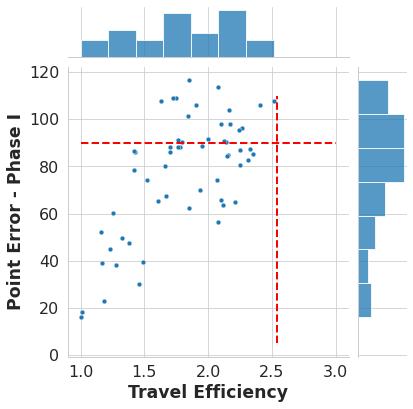

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, y="Point_PreError", x="efficiency")
g.ax_joint.set_ylabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_xlabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([1,3], [90,90], 'r--', linewidth = 2)
g.ax_joint.plot([2.54,2.54],[5,110] , 'r--', linewidth = 2)
plt.show()

In [ ]:
round(sub_performance[['efficiency','Point_PreError','Point_PostError']].corr(),2)

,efficiency,Point_PreError,Point_PostError
efficiency,1.00,0.66,0.70
Point_PreError,0.66,1.00,0.71
Point_PostError,0.70,0.71,1.00


In [ ]:
sub_performance[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.663936,0.696128
Point_PreError,0.663936,1.000000,0.712325
Point_PostError,0.696128,0.712325,1.000000


In [ ]:
pearsonr_ci(sub_performance['efficiency'],sub_performance['Point_PreError'])

(0.66393593606108,
 1.8043742295573814e-08,
 0.48774896289221237,
 0.7881529501056024)

In [ ]:
#Travel Efficiency - SplitHalf:0.72
print(round(0.663936/math.sqrt(0.79*0.72),2))
print(round(0.696128/math.sqrt(0.72*0.80),2))
print(round(0.712325/math.sqrt(0.79*0.80),2))

0.88
0.92
0.9


## K-mean Clustering

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(sub_performance[['Point_PreError','Point_PostError','efficiency']])
# X = sc.fit_transform(sub_performance[['Point_PreError','efficiency']])

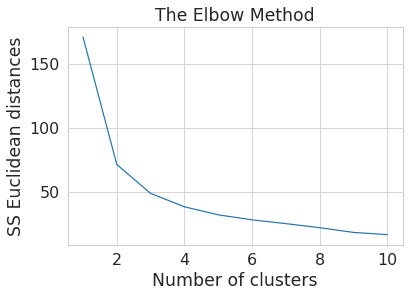

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS Euclidean distances')
plt.show()

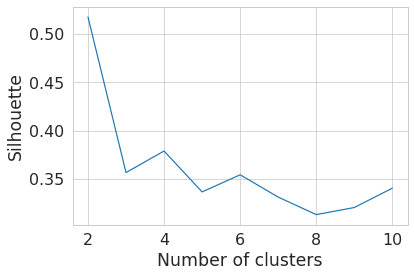

In [ ]:
silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  score = silhouette_score(X,kmeans.labels_)
  silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
print("low spatial: {}".format(sum(y_kmeans == 1)))
print("high spatial: {}".format(sum(y_kmeans == 0)))

low spatial: 14
high spatial: 43


In [ ]:
sub_performance['high_spatial']=y_kmeans
dVR_l = sub_performance[sub_performance.high_spatial==0]
dVR_h = sub_performance[sub_performance.high_spatial==1]

## High / Low Spatial Groups Performance and Reliability

In [ ]:
pd.set_option('display.max_columns',500)
round(sub_performance.groupby('high_spatial')[['Point_PreError','efficiency','Point_PostError']].describe(),2)

Point_PreError                                                    \
                      count   mean    std    min    25%    50%    75%     max   
high_spatial                                                                    
0                      43.0  88.30  14.92  56.32  80.37  88.16  98.03  116.58   
1                      14.0  43.79  19.36  16.16  32.01  42.42  51.53   86.21   

             efficiency                                            \
                  count  mean   std   min   25%   50%   75%   max   
high_spatial                                                        
0                  43.0  1.98  0.27  1.42  1.76  2.07  2.17  2.51   
1                  14.0  1.29  0.18  1.00  1.18  1.27  1.41  1.67   

             Point_PostError                                                    
                       count   mean    std    min    25%    50%    75%     max  
high_spatial                                                                    
0                       43.0  77.06  17.80  42.05  63.84  75.74  87.66  113.11  
1                       14.0  33.71  11.74  14.32  26.76  34.16  41.26   59.26

In [ ]:
round(sub_performance.groupby('high_spatial')[['Point_PreError','efficiency','Point_PostError']].agg({skew,kurtosis}),2)

Point_PreError          efficiency          Point_PostError  \
                       skew kurtosis       skew kurtosis            skew   
high_spatial                                                               
0                     -0.18    -0.57      -0.24     -0.8            0.25   
1                      0.50    -0.12       0.26     -0.4            0.29   

                       
             kurtosis  
high_spatial           
0               -0.65  
1               -0.03

In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(dVR_l['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(dVR_l['Point_PreError'],90)
print("Efficiency differ from 2.54")
print(stats.ttest_1samp(dVR_l['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(dVR_l['efficiency'], 2.54)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-0.7473141298734111, pvalue=0.45903762710214424)
Point Phase I CI
95% Confidence Interval: (83.70878831317489, 92.89096688878351)
cohen_d -0.11
Efficiency differ from 2.54
Ttest_1sampResult(statistic=-13.43266634817243, pvalue=8.46854861998661e-17)
Efficiency CI
95% Confidence Interval: (1.8961438959665557, 2.064336945947883)
cohen_d -2.05


In [ ]:
pp_l = valid_pp1[valid_pp1.Subject.isin(dVR_l.Subject.to_list())]
pp_h = valid_pp1[valid_pp1.Subject.isin(dVR_h.Subject.to_list())]
pp2_l = valid_pp2[valid_pp2.Subject.isin(dVR_l.Subject.to_list())]
pp2_h = valid_pp2[valid_pp2.Subject.isin(dVR_h.Subject.to_list())]
wf_l = valid_wf[valid_wf.Subject.isin(dVR_l.Subject.to_list())]
wf_h = valid_wf[valid_wf.Subject.isin(dVR_h.Subject.to_list())]

In [ ]:
%%R -i pp_l
set.seed(123)
splithalf(data=pp_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 43          0.36   0.06     0.6
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.36, 95% CI [0.06, 0.6]"


In [ ]:
%%R -i pp_h
set.seed(123)
splithalf(data=pp_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 14          0.74   0.48     0.9
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.74, 95% CI [0.48, 0.9]"


In [ ]:
%%R -i wf_l
set.seed(123)
splithalf(data=wf_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 43          0.29  -0.02    0.54
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.29, 95% CI [-0.02, 0.54]"


In [ ]:
%%R -i wf_h
set.seed(123)
splithalf(data=wf_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 14          0.57   0.06    0.88
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.57, 95% CI [0.06, 0.88]"


In [ ]:
%%R -i pp2_l
set.seed(123)
splithalf(data=pp2_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 43          0.55   0.34    0.72
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.55, 95% CI [0.34, 0.72]"


In [ ]:
%%R -i pp2_h
set.seed(123)
splithalf(data=pp2_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 14          0.47  -0.04    0.81
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.47, 95% CI [-0.04, 0.81]"


In [ ]:
round(dVR_l[['Point_PreError','efficiency','Point_PostError']].corr(),2)

,Point_PreError,efficiency,Point_PostError
Point_PreError,1.00,0.07,0.24
efficiency,0.07,1.00,0.28
Point_PostError,0.24,0.28,1.00


In [ ]:
dVR_l[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.070991,0.279354
Point_PreError,0.070991,1.000000,0.243068
Point_PostError,0.279354,0.243068,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.29
print(0.070991/math.sqrt(0.29*0.36))
print(0.279354/math.sqrt(0.29*0.55))
print(0.243068/math.sqrt(0.36*0.55))
print("low Spatial: Efficiency vs. Phase I")
print(pearsonr_ci(dVR_l.efficiency,dVR_l.Point_PreError))

0.2197116292087848
0.6994787908033374
0.5462547072307177
low Spatial: Efficiency vs. Phase I
(0.070991312630753, 0.6509987560332341, -0.2343492982635174, 0.3635829292130336)


In [ ]:
bi_pr_test(0.070991,43)

t-statistic = 0.456 pvalue = 0.6510 df = 41
95CI = [-0.23, 0.36]


In [ ]:
bi_pr_test(0.279354,43)

t-statistic = 1.863 pvalue = 0.0697 df = 41
95CI = [-0.02, 0.53]


In [ ]:
bi_pr_test(0.5462547072307177,43)

t-statistic = 4.176 pvalue = 0.0002 df = 41
95CI = [0.29, 0.73]


In [ ]:
dVR_h[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.605984,0.299764
Point_PreError,0.605984,1.000000,0.634451
Point_PostError,0.299764,0.634451,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.57
print(0.605984/math.sqrt(0.74*0.57))
print(0.299764/math.sqrt(0.57*0.47))
print(0.634451/math.sqrt(0.74*0.47))

0.933056343427064
0.5791527441595719
1.07580435345066


In [ ]:
pearsonr_ci(dVR_h.efficiency,dVR_h.Point_PreError)

(0.6059840276252235,
 0.02161728388381748,
 0.11113787527760491,
 0.8600408655691267)

In [ ]:
bi_pr_test(0.605984,14)

t-statistic = 2.639 pvalue = 0.0216 df = 12
95CI = [0.11, 0.86]


In [ ]:
bi_pr_test(0.5791527441595719,14)

t-statistic = 2.461 pvalue = 0.0300 df = 12
95CI = [0.07, 0.85]


In [ ]:
dvrl = pearsonr_ci(dVR_l['efficiency'],dVR_l['Point_PreError'])
dvrh = pearsonr_ci(dVR_h['efficiency'],dVR_h['Point_PreError'])

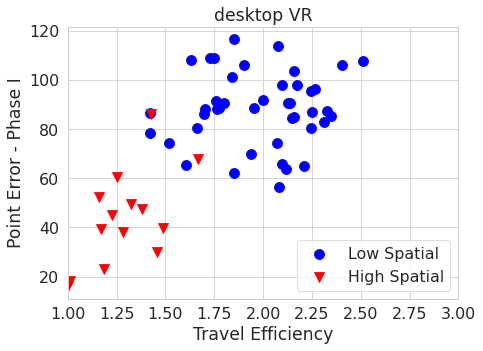

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(dVR_l['efficiency'], dVR_l['Point_PreError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(dVR_h['efficiency'], dVR_h['Point_PreError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('desktop VR')
plt.ylabel('Point Error - Phase I')
plt.xlabel('Travel Efficiency')
plt.xlim(1.0,3)
plt.legend()
plt.show()

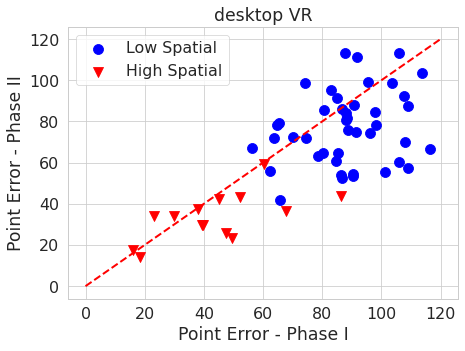

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(dVR_l['Point_PreError'], dVR_l['Point_PostError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(dVR_h['Point_PreError'], dVR_h['Point_PostError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('desktop VR')
plt.xlabel('Point Error - Phase I')
plt.ylabel('Point Error - Phase II')
plt.plot([0,120], [0,120], 'r--', linewidth = 2)
plt.legend()
plt.show()

# All Pointing Trials (27)
### but removed unsuccessful shortcutting trials and the corresponding pointing trials.

In [ ]:
# read and preprocess the wayfinding data to get efficiency
strategy = pd.read_csv('strategy.csv')
strategy['ID'] = strategy.TrialID.apply(lambda x: int(x.split('_')[1]))

wftrajc = pd.read_csv("ProcessedData/analyzed_trajectory.csv")
trial_info = pd.read_csv("desktop_shortcut_trial_info.csv")
wf = wftrajc.merge(strategy[['Subject','ID','human_coding']]\
                   , how = 'left', left_on = ['Subject','TrialID'], right_on = ['Subject','ID'])\
            .merge(trial_info[['TrialID','short_dis','learn_dis']]\
                   , how = 'left', on = 'TrialID')\
            .drop(['ID'],axis=1)

def efficiency(x):
  if x['human_coding'] != 'Failure' and x['grid_distance']+0.001 >= x['short_dis']:
    return x['grid_distance']/x['short_dis']
  elif x['human_coding'] != 'Failure' and x['grid_distance']+0.001 < x['short_dis']:
    return 1
  else: return np.nan

wf['efficiency']=wf.apply(efficiency, axis=1)
# wf['efficiency']= wf.groupby('Subject')['efficiency'].transform(lambda x: x.fillna(x.max()))

# remove participants and trials whose are not qualified due to low successful rates
sub_fail = wf.groupby(['Subject']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
trial_fail = wf.groupby(['TrialID']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')

p_sub=sub_fail[sub_fail['total_failure']>6]['Subject'].tolist()
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()

# excluded unsuccessful participants and trials
valid_wf = wf.loc[~(wf['TrialID'].isin(p_trial) | wf['Subject'].isin(p_sub)),:]

# read pointing data
pp1 = pd.read_csv("ProcessedData/pointingPhase1.csv")
pp2 = pd.read_csv("ProcessedData/pointingPhase2.csv")

# remove the corresponding trials where participants failed in the wayfinding
def recode_point_trial_id (x):
  if 'new' in x:
    return int(x.split('_')[1])+30
  else: return int(x.split('_')[1])

pp1['TrialID'] = pp1.DSP_Trial.apply(recode_point_trial_id)
pp1_matched = pp1[pp1.Subject.isin(valid_wf.Subject.to_list())]

perf = pp1_matched.merge(valid_wf,how='left',on=['Subject','TrialID'])
point_matched = perf[~((perf.efficiency.isna())&(perf.TrialID<30))].groupby('Subject')['AngularError'].mean().reset_index().rename(columns = {'AngularError':'matchedError'})
point_nonmatched = perf.groupby('Subject')['AngularError'].mean().reset_index().rename(columns = {'AngularError':'nonmatchedError'})
point_compare = point_matched.merge(point_nonmatched,how="left",on="Subject")


pp2_sub = pp2.groupby('Subject')['AngularError'].mean().reset_index().\
              rename(columns={'AngularError':'Point_PostError'})
wf_sub = valid_wf.groupby('Subject')[['efficiency','Time']].mean().reset_index()
wf_sub_c = valid_wf[valid_wf.human_coding=="Failure"].groupby('Subject')[['TrialID']].count().reset_index().rename(columns={'TrialID':'num_Failures'})
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='Subject', how='outer'), [point_compare,pp2_sub,wf_sub,wf_sub_c]).dropna(subset=['matchedError','nonmatchedError','efficiency']).fillna(0)
sub_performance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          57 non-null     int64  
 1   matchedError     57 non-null     float64
 2   nonmatchedError  57 non-null     float64
 3   Point_PostError  57 non-null     float64
 4   efficiency       57 non-null     float64
 5   Time             57 non-null     float64
 6   num_Failures     57 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.6 KB


## Overall Performance
**Note that the results presented below did not substantially differ from the ones reported in the main text**

In [ ]:
#Note that the unmatched Error is the same error reported in the main text.
round(sub_performance[['matchedError','nonmatchedError','efficiency','Point_PostError']].describe().transpose(),2)

,count,mean,std,min,25%,50%,75%,max
matchedError,57.0,73.24,24.40,15.62,56.31,77.35,90.87,109.52
nonmatchedError,57.0,73.71,23.22,18.85,61.74,77.15,89.00,105.26
efficiency,57.0,1.77,0.38,1.00,1.49,1.76,2.09,2.50
Point_PostError,57.0,65.37,23.40,15.89,51.93,64.96,81.93,104.67


In [ ]:
print("Skewness for the measures")
print(np.round(skew(sub_performance[['matchedError','nonmatchedError','efficiency','Point_PostError']]),2))
print("Kurtosis for the measures")
print(np.round(kurtosis(sub_performance[['matchedError','nonmatchedError','efficiency','Point_PostError']]),2))

Skewness for three measures
[-0.66 -0.69 -0.2  -0.25]
Kurtosis for three measures
[-0.34 -0.27 -0.9  -0.83]


In [ ]:
print("Point Phase I (matched) differ from 90")
print(stats.ttest_1samp(sub_performance['matchedError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(sub_performance['matchedError'],90)
print("Efficiency (remove unsuccessful trials) differ from 2.54")
print(stats.ttest_1samp(sub_performance['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(sub_performance['efficiency'], 2.54)

Point Phase I (matched) differ from 90
Ttest_1sampResult(statistic=-5.185009053958597, pvalue=3.0760850832055777e-06)
Point Phase I CI
95% Confidence Interval: (66.76435170779365, 79.71509722618617)
cohen_d -0.69
Efficiency (remove unsuccessful trials) differ from 2.54
Ttest_1sampResult(statistic=-15.283517534298694, pvalue=1.2310960619233512e-21)
Efficiency CI
95% Confidence Interval: (1.6731662967473928, 1.874068807716877)
cohen_d -2.02


In [ ]:
valid_pp1 = perf[~((perf.efficiency.isna())&(perf.TrialID<30))]

In [ ]:
%%R -i valid_pp1
set.seed(123)
splithalf(data=valid_pp1,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.83   0.76    0.89
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.83, 95% CI [0.76, 0.89]"


**Note that the internal consistency is the same as the one reported in the main text**

In [ ]:
wf_internalconsistency = valid_wf.dropna(subset=['efficiency'])

In [ ]:
%%R -i wf_internalconsistency
set.seed(123)
splithalf(data= wf_internalconsistency,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.62   0.46    0.76
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.62, 95% CI [0.46, 0.76]"


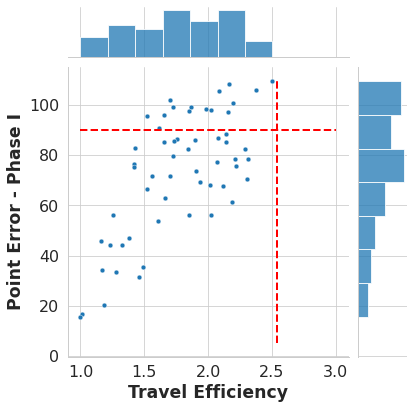

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, y="matchedError", x="efficiency")
g.ax_joint.set_ylabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_xlabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([1,3], [90,90], 'r--', linewidth = 2)
g.ax_joint.plot([2.54,2.54],[5,110] , 'r--', linewidth = 2)
plt.show()

In [ ]:
round(sub_performance[['efficiency','matchedError','Point_PostError']].corr(),2)

## K-mean Clustering
**Note that the clusters did not differ from the results reported in the main text**

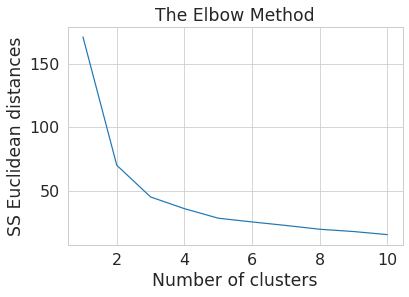

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(sub_performance[['matchedError','Point_PostError','efficiency']])

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS Euclidean distances')
plt.show()

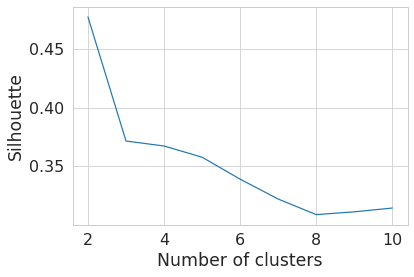

In [ ]:
silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  score = silhouette_score(X,kmeans.labels_)
  silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
print("low spatial: {}".format(sum(y_kmeans == 1)))
print("high spatial: {}".format(sum(y_kmeans == 0)))

low spatial: 37
high spatial: 20


In [ ]:
sub_performance['low_spatial']=y_kmeans
dVR_l = sub_performance[sub_performance.low_spatial==1]
dVR_h = sub_performance[sub_performance.low_spatial==0]

## High / Low Spatial Groups Performance and Reliability

In [ ]:
pd.set_option('display.max_columns',500)
round(sub_performance.groupby('low_spatial')[['matchedError','efficiency','Point_PostError','num_Failures']].describe(),2)

matchedError                                                    \
                   count   mean    std    min    25%    50%    75%     max   
low_spatial                                                                  
0                   20.0  48.80  20.46  15.62  34.08  46.56  65.06   83.12   
1                   37.0  86.45  13.94  56.29  77.35  86.17  98.00  109.52   

            efficiency                                            \
                 count  mean   std   min   25%   50%   75%   max   
low_spatial                                                        
0                 20.0  1.38  0.23  1.00  1.22  1.40  1.51  1.85   
1                 37.0  1.99  0.25  1.52  1.76  2.02  2.17  2.50   

            Point_PostError                                                    \
                      count   mean    std    min    25%    50%    75%     max   
low_spatial                                                                     
0                      20.0  40.50  14.41  15.89  29.48  39.17  52.01   69.41   
1                      37.0  78.82  14.60  52.56  64.96  76.93  92.70  104.67   

            num_Failures                                       
                   count  mean   std  min  25%  50%  75%  max  
low_spatial                                                    
0                   20.0  0.10  0.45  0.0  0.0  0.0  0.0  2.0  
1                   37.0  2.03  1.40  0.0  1.0  2.0  3.0  5.0

In [ ]:
stats.ttest_rel(dVR_l.matchedError, dVR_l.nonmatchedError)

Ttest_relResult(statistic=0.20706617102245808, pvalue=0.8371249921961161)

In [ ]:
round(sub_performance.groupby('low_spatial')[['matchedError','efficiency','Point_PostError']].agg({skew,kurtosis}),2)

matchedError       efficiency       Point_PostError      
                kurtosis  skew   kurtosis  skew        kurtosis  skew
low_spatial                                                          
0                  -1.03  0.00      -0.54  0.21           -0.87  0.22
1                  -0.83 -0.23      -0.84 -0.12           -1.10  0.10

In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(dVR_l['matchedError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(dVR_l['matchedError'],90)
print("Efficiency differ from 2.54")
print(stats.ttest_1samp(dVR_l['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(dVR_l['efficiency'], 2.54)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-1.5492136890258197, pvalue=0.13007774741578954)
Point Phase I CI
95% Confidence Interval: (81.80254489638375, 91.09736153482703)
cohen_d -0.25
Efficiency differ from 2.54
Ttest_1sampResult(statistic=-13.45034436027892, pvalue=1.3130572337445352e-15)
Efficiency CI
95% Confidence Interval: (1.9035058173241535, 2.070301717971951)
cohen_d -2.21


In [ ]:
pp_l = valid_pp1[valid_pp1.Subject.isin(dVR_l.Subject.to_list())]
pp_h = valid_pp1[valid_pp1.Subject.isin(dVR_h.Subject.to_list())]
wf_l = wf_internalconsistency[wf_internalconsistency.Subject.isin(dVR_l.Subject.to_list())]
wf_h = wf_internalconsistency[wf_internalconsistency.Subject.isin(dVR_h.Subject.to_list())]

In [ ]:
%%R -i pp_l
set.seed(123)
splithalf(data=pp_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 37          0.42   0.13    0.65
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.42, 95% CI [0.13, 0.65]"


In [ ]:
%%R -i pp_h
set.seed(123)
splithalf(data=pp_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 20          0.81   0.65    0.92
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.81, 95% CI [0.65, 0.92]"


In [ ]:
%%R -i wf_l
set.seed(123)
splithalf(data=wf_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 37         -0.13  -0.43    0.28
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was -0.13, 95% CI [-0.43, 0.28]"


In [ ]:
%%R -i wf_h
set.seed(123)
splithalf(data=wf_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 20          0.63   0.33    0.85
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.63, 95% CI [0.33, 0.85]"


In [ ]:
round(dVR_l[['efficiency','matchedError','nonmatchedError','Point_PostError']].corr(),2)

,efficiency,matchedError,nonmatchedError,Point_PostError
efficiency,1.00,0.02,-0.01,0.20
matchedError,0.02,1.00,0.96,0.20
nonmatchedError,-0.01,0.96,1.00,0.23
Point_PostError,0.20,0.20,0.23,1.00


In [ ]:
round(dVR_h[['efficiency','matchedError','nonmatchedError','Point_PostError']].corr(),2)

,efficiency,matchedError,nonmatchedError,Point_PostError
efficiency,1.00,0.64,0.63,0.63
matchedError,0.64,1.00,1.00,0.78
nonmatchedError,0.63,1.00,1.00,0.78
Point_PostError,0.63,0.78,0.78,1.00


# Linear mixed model

In [ ]:
# read and preprocess the wayfinding data to get efficiency
strategy = pd.read_csv('strategy.csv')
strategy['ID'] = strategy.TrialID.apply(lambda x: int(x.split('_')[1]))

wftrajc = pd.read_csv("ProcessedData/analyzed_trajectory.csv")
trial_info = pd.read_csv("desktop_shortcut_trial_info.csv")
wf = wftrajc.merge(strategy[['Subject','ID','human_coding']]\
                   , how = 'left', left_on = ['Subject','TrialID'], right_on = ['Subject','ID'])\
            .merge(trial_info[['TrialID','short_dis','learn_dis']]\
                   , how = 'left', on = 'TrialID')\
            .drop(['ID'],axis=1)

def efficiency(x):
  if x['human_coding'] != 'Failure' and x['grid_distance']+0.001 >= x['short_dis']:
    return x['grid_distance']/x['short_dis']
  elif x['human_coding'] != 'Failure' and x['grid_distance']+0.001 < x['short_dis']:
    return 1
  else: return np.nan

wf['efficiency']=wf.apply(efficiency, axis=1)
# wf['efficiency']= wf.groupby('Subject')['efficiency'].transform(lambda x: x.fillna(x.max()))

# remove participants and trials whose are not qualified due to low successful rates
sub_fail = wf.groupby(['Subject']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
trial_fail = wf.groupby(['TrialID']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')

p_sub=sub_fail[sub_fail['total_failure']>6]['Subject'].tolist()
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()

# excluded unsuccessful participants and trials
valid_wf = wf.loc[~(wf['TrialID'].isin(p_trial) | wf['Subject'].isin(p_sub)),:]

# read pointing data
pp1 = pd.read_csv("ProcessedData/pointingPhase1.csv")
pp2 = pd.read_csv("ProcessedData/pointingPhase2.csv")

# remove the corresponding trials where participants failed in the wayfinding
def recode_point_trial_id (x):
  if 'new' in x:
    return int(x.split('_')[1])+30
  else: return int(x.split('_')[1])

pp1['TrialID'] = pp1.DSP_Trial.apply(recode_point_trial_id)

perf = valid_wf.merge(pp1,how='left',on=['Subject','TrialID'])

In [ ]:
perf_lmm= perf[['Subject','TrialID','efficiency','AngularError']]

In [ ]:
%%R
install.packages("lme4")
# library(lme4)
# print(summary(lmer('efficiency ~ AngularError + (1|Subject) + (1|TrialID)', data=perf_lmm)))

In [ ]:
%%R -i perf_lmm
library(lme4)
print(summary(lmer('efficiency ~ AngularError + (1|Subject) + (1|TrialID)', data=perf_lmm)))

Linear mixed model fit by REML ['lmerMod']
Formula: efficiency ~ AngularError + (1 | Subject) + (1 | TrialID)
   Data: perf_lmm

REML criterion at convergence: 2515.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8969 -0.5098 -0.1099  0.3069  7.1571 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.08185  0.2861  
 TrialID  (Intercept) 0.24239  0.4923  
 Residual             0.62160  0.7884  
Number of obs: 1006, groups:  Subject, 57; TrialID, 19

Fixed effects:
              Estimate Std. Error t value
(Intercept)  1.6172561  0.1279720  12.638
AngularError 0.0019260  0.0005146   3.743

Correlation of Fixed Effects:
            (Intr)
AngularErrr -0.309


In [ ]:
# import statsmodels.api as sm
import statsmodels.formula.api as smf

perf_lmm["group"] = 1

vcf = {"TrialID": "0+C(TrialID)", "Subject": "0+C(Subject)"}

# md = smf.mixedlm("efficiency ~ AngularError", perf_lmm, groups = perf_lmm["group"], vc_formula=vcf, re_formula ="0").fit()

# md.summary()
# mdf = md.fit()

# print(mdf.summary())



<ipython-input-22-60079f882b65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_lmm["group"] = 1


In [ ]:
perf_lmm.head()

,Subject,TrialID,efficiency,AngularError,group
0,605,2,1.000000,77.0,1
1,605,3,1.000000,5.0,1
2,605,4,1.358744,123.0,1
3,605,5,1.151515,110.0,1
4,605,6,1.000000,164.0,1


In [ ]:
perf_lmm2 = perf_lmm.dropna()

md = smf.mixedlm("efficiency ~ AngularError", perf_lmm2, groups = perf_lmm2["group"], vc_formula=vcf, re_formula ="0").fit()

md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: efficiency
No. Observations: 1006    Method:             REML      
No. Groups:       1       Scale:              0.6216    
Min. group size:  1006    Log-Likelihood:     -1257.9513
Max. group size:  1006    Converged:          Yes       
Mean group size:  1006.0                                
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.617    0.128 12.596 0.000  1.366  1.869
AngularError   0.002    0.001  3.643 0.000  0.001  0.003
Subject Var    0.082    0.030                           
TrialID Var    0.242    0.108                           
========================================================

"""